## Data loading and preprocessing

We are loading a dataset consisting of Amazon product reviews for products from the category "Electronics". We do not know what types of products are covered by these reviews and we want to uncover that by means of applying **topic modeling** (LDA) on this corpus of reviews 

In [2]:
import pandas as pd

reviews = pd.read_csv('reviews.csv', delimiter = '\t') # in our file, the values are actually TAB-separated
reviews


label  score                                            content
0      NEG    2.0   cons tips extremely easy on carpet and if you...
1      NEG    1.0   It's a nice look, but it tips over very easil...
2      NEG    1.0   I have bought and returned three of these uni...
3      NEG    1.0   I knew these were inexpensive CD cases, but I...
4      NEG    2.0   I used a 25 pack of these doing DVD backups, ...
...    ...    ...                                                ...
1795   POS    5.0   I just recieved my HDMI cable and am very imp...
1796   POS    5.0   This is the perfect keyboard ( I know cuz I a...
1797   POS    5.0   SanDisk has done it again. They never seem to...
1798   POS    5.0   Fast shipping, Very happy with the GARMIN. Th...
1799   POS    5.0   The SanDisk 1GB Micro SD Card arrived quickly...

[1800 rows x 3 columns]

### Preprocessing

We next want to preprocess our review texts to eliminate as much of the "noise" that could affect the topic modeling. We will apply common text preprocessing: 

- Tokenization: we split the texts into words/tokens
- Stopword and punctuation removal: we eliminate all tokens that are in the list of stopwords (and puncutation)
- Additionally, we remove all non-content words, i.e., all words with part-of-speech-tags that do not correspond to nouns, verbs, adjectives, ...

We will use SpaCy to perform tokenization and filtering. 
- To do that, one first needs to install spacy and download the corresponding model
- We will use the model "en_core_web_md" that contains tokenization, part-of-speech tagging and other models for English

To install spacy, run the following in command line: 
- *pip install spacy*

To download the model, run the following in command line: 
- *python -m spacy download en_core_web_md*


In [3]:
import spacy
import wordcloud
from wordcloud import STOPWORDS

# removing the repetitions if there are any, converting the list to set
stopwords = set(list(STOPWORDS) + ['.', "?", "!", ",", "(", ")", ":", ";", "\"", "'", "=", "-"])
stop_tags = ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
print(stopwords)

nlp = spacy.load("en_core_web_md")

C:\Goran\System\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:246: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


{'your', 'being', 'which', ';', 'over', 'other', 'has', "i'm", 'had', 'why', '.', "doesn't", "we'll", ':', "when's", 'for', 'did', "it's", 'yourselves', 'after', "i'll", 'once', "shouldn't", "let's", "how's", 'themselves', 'a', "hasn't", 'who', 'each', 'all', "there's", 'hers', 'herself', 'having', 'those', "they'd", "you'd", 'cannot', 'down', "mustn't", 'same', '-', 'how', 'most', 'own', 'theirs', "he'll", 'do', 'during', 'here', 'therefore', "they'll", 'these', "wasn't", 'just', "you're", 'http', "aren't", 'since', 'them', 'from', 'also', 'there', 'doing', 'does', 'than', 'such', "weren't", 'until', 'were', 'what', '?', 'in', 'about', 'too', "we've", 'while', 'should', 'shall', 'himself', ',', "she's", 'at', 'between', 'both', "he'd", "she'd", "you've", 'against', 'then', 'could', "she'll", "they're", 'above', "we'd", 'we', 'into', 'she', 'have', "here's", "why's", 'can', 'you', 'of', 'his', 'he', "don't", "won't", 'yourself', "where's", ')', 'otherwise', '(', 'hence', 'but', 'their'

In [4]:
# we're tokenizing all reviews, and from each eliminating stopwords and words with non-content POS-tags
reviews["tokens"] = reviews.content.apply(lambda x: [t.lemma_.lower() for t in nlp(x, disable=["parser", "ner"]) if (t.text.strip() != "" and (t.text.lower() not in stopwords) and t.pos_ not in stop_tags)])


In [5]:
ind = 45
reviews.iloc[ind].tokens

['be',
 'consumer',
 'sandisk',
 'usb',
 'flash',
 'drive',
 'use',
 'couple',
 'sandisk',
 'flash',
 'drive',
 'i.e.',
 'mb',
 'mini',
 'mb',
 'mini',
 'buy',
 'product',
 'performance',
 'wise',
 'particular',
 'product',
 'good',
 'be',
 'take',
 'long',
 'time',
 'copy',
 'file',
 'computer',
 'be',
 'take',
 'long',
 'time',
 'delete',
 'file',
 'disk',
 'return',
 'amazon',
 'look',
 'mini',
 'product',
 'sandisk',
 'doubt',
 'micro',
 'product',
 'capacity',
 'mb',
 'be',
 'plan',
 'buy',
 'mb',
 'gb',
 'sandisk',
 'mini',
 'usb',
 'flash',
 'drive',
 'buy',
 'good',
 'one',
 'waste',
 'time',
 'product']

## Peparation for topic modeling with LDA

We will carry out topic modeling with the implementation of LDA from the popular library *gensim*. To be able to apply LDA from gensim, we first need to prepare some data structures, namely: the *dictionary* of words we will use as the vocabulary over which to carry out topic models. 

We can influence on how big the dictionary will be, via the parameters of the *filter_extremes* method:  

- by setting the minimal number of documents (reviews) in which the token has to appear to be included in the dictionary (this eliminates the most infrequent terms, unlikely to be relevant for any topic)

- by setting the maximal percentage of documents in which the token is allowed to appear (this eliminates the most frequent terms, likely to be "part of" every topic) 

In [7]:
from gensim.corpora.dictionary import Dictionary
dictionary = Dictionary(reviews['tokens'])
dictionary.filter_extremes(no_below=5, no_above=0.1)

l = list(dictionary.items())
print(l)
print(len(l))


[(0, 'bottom'), (1, 'break'), (2, 'cd'), (3, 'con'), (4, 'design'), (5, 'fit'), (6, 'gap'), (7, 'guess'), (8, 'guide'), (9, 'hold'), (10, 'hole'), (11, 'individual'), (12, 'loose'), (13, 'lot'), (14, 'metal'), (15, 'pain'), (16, 'piece'), (17, 'pro'), (18, 'pull'), (19, 'put'), (20, 'slot'), (21, 'stack'), (22, 'tip'), (23, 'top'), (24, 'whole'), (25, 'advice'), (26, 'box'), (27, 'invest'), (28, 'money'), (29, 'nice'), (30, 'picture'), (31, 'save'), (32, 'show'), (33, 'sturdy'), (34, 'surface'), (35, 'complete'), (36, 'defective'), (37, 'disc'), (38, 'dvd'), (39, 'error'), (40, 'player'), (41, 'point'), (42, 'return'), (43, 'rip'), (44, 'skip'), (45, 'slight'), (46, 'system'), (47, 'useless'), (48, 'can'), (49, 'case'), (50, 'inexpensive'), (51, 'open'), (52, 'backup'), (53, 'brand'), (54, 'burner'), (55, 'fail'), (56, 'failure'), (57, 'firmware'), (58, 'first'), (59, 'frustration'), (60, 'high'), (61, 'last'), (62, 'learn'), (63, 'mention'), (64, 'pack'), (65, 'package'), (66, 'people

We're next creating the corpus as a set of sparse document vectors: for this we're using the *doc2bow* function of the gensim Dictionary object: 

In [8]:
corpus = [dictionary.doc2bow(a) for a in reviews['tokens']]
corpus


[[(0, 1),
  (1, 1),
  (2, 7),
  (3, 1),
  (4, 2),
  (5, 2),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 2),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 3),
  (22, 1),
  (23, 1),
  (24, 1)],
 [(2, 2),
  (9, 1),
  (13, 1),
  (22, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 2),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1)],
 [(29, 1),
  (35, 1),
  (36, 1),
  (37, 2),
  (38, 1),
  (39, 1),
  (40, 2),
  (41, 1),
  (42, 2),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1)],
 [(1, 1), (2, 1), (16, 1), (48, 1), (49, 1), (50, 1), (51, 1)],
 [(7, 1),
  (31, 1),
  (37, 1),
  (38, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 2),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1)],
 [(37, 4),
  (49, 1),
  (54, 1),

## Running topic modeling (LDA)

Having prepared (1) dictionary (i.e., vocabulary) and (2) corpus (i.e., sparse document vectors over the terms of the vocabulary), we are now ready to execute/run topic modeling. 

- *gensim* contains several classes for this. The standard one is *gensim.models.ldamodel.LdaModel*. We will, however, resort to *gensim.models.LdaMulticore*, which allows a faster, multi-core training of the LDA model. Multicore means that multiple processor units (CPUs) will be used, if available, to parallelize the computation. 

*gensim.models.LdaMulticore* takes, among others, the following parameters: 
- *corpus*: the list of sparse document bag-of-word vectors (which we've built already)
- *id2word*: the mapping from vocabulary IDs to actual tokens, which is exactly what our "dictionary" contains
- *num_topics*: number of topics we would like to induce
- *iterations*: max. number of iterations through the corpus when inferring the topic distribution of a corpus
- *workers*: how many parallel threads (i.e., CPUs) to use for training the topic model  



In [9]:
from gensim.models import LdaMulticore
# alternative: gensim.models.ldamodel.LdaModel

lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=20, workers = 4)

In [10]:
lda_model.print_topics(num_words=5)


[(0,
  '0.030*"cable" + 0.008*"card" + 0.008*"monster" + 0.008*"camera" + 0.007*"hdmi"'),
 (1,
  '0.011*"device" + 0.008*"file" + 0.008*"headphone" + 0.007*"bass" + 0.007*"software"'),
 (2,
  '0.010*"screen" + 0.009*"play" + 0.008*"disc" + 0.008*"cd" + 0.007*"system"'),
 (3,
  '0.015*"battery" + 0.013*"car" + 0.012*"power" + 0.007*"speaker" + 0.007*"laptop"'),
 (4,
  '0.014*"set" + 0.013*"paper" + 0.010*"photo" + 0.009*"dvd" + 0.007*"printer"'),
 (5,
  '0.008*"card" + 0.008*"old" + 0.008*"headphone" + 0.007*"keyboard" + 0.007*"dvd"'),
 (6,
  '0.014*"mouse" + 0.008*"speaker" + 0.007*"set" + 0.007*"usb" + 0.006*"week"'),
 (7,
  '0.017*"ear" + 0.013*"headphone" + 0.011*"mouse" + 0.007*"case" + 0.007*"ipod"'),
 (8,
  '0.033*"phone" + 0.014*"speaker" + 0.011*"headphone" + 0.010*"cable" + 0.009*"battery"'),
 (9,
  '0.015*"dvd" + 0.008*"play" + 0.008*"disc" + 0.007*"record" + 0.007*"mouse"'),
 (10,
  '0.019*"cable" + 0.009*"printer" + 0.008*"phone" + 0.008*"support" + 0.007*"headphone"'),
 (1

How are topics represented in documents? Or, put differently, which documents belong to which topics?
- This information is stored in our *lda_model* object after training
- We can access the corpus with lda_model[corpus] and then index that list for the document we're interested in

In [13]:

ind = 35
print(lda_model[corpus][ind])
reviews["content"][ind]

[(11, 0.88124305)]


" I never even traveled with it. It just stopped working completely making me lose data. NEVER AGAIN I'll buy anything from this company. This drive is a piece of rubbish!"

## Evaluating topics

- Question #1: How good are the topics we induced? 
- Question #2: We define the number of topics in advance. What is the optimal number of topics? Optimal w.r.t. what criteria?

One widely adopted way to evaluate topic models is with various coherence measures: these quantify (in various ways) the semantic similarity / lexical association between the most prominent words of each topic. If the words that have the highest weight in each topic are not semantically similar/associated, then the topic is not coherent. 

There is a number of coherence measures already implemented in *gensim* in the class *gensim.modelsCoherenceModel*. We will use some of those to quantify the coherence of the topics we induced. 
 

In [14]:
# We will execute topic modeling 20 times, each time with the different number of topics
max_topics = 30 
models = []

for i in range(max_topics):
    print("Training LDA with " + str(i+1) + " topics.")
    
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=i+1, workers = 4, random_state=100)
    models.append(lda_model)
          
    print("Done.")    

Training LDA with 1 topics.
Done.
Training LDA with 2 topics.
Done.
Training LDA with 3 topics.
Done.
Training LDA with 4 topics.
Done.
Training LDA with 5 topics.
Done.
Training LDA with 6 topics.
Done.
Training LDA with 7 topics.
Done.
Training LDA with 8 topics.
Done.
Training LDA with 9 topics.
Done.
Training LDA with 10 topics.
Done.
Training LDA with 11 topics.
Done.
Training LDA with 12 topics.
Done.
Training LDA with 13 topics.
Done.
Training LDA with 14 topics.
Done.
Training LDA with 15 topics.
Done.
Training LDA with 16 topics.
Done.
Training LDA with 17 topics.
Done.
Training LDA with 18 topics.
Done.
Training LDA with 19 topics.
Done.
Training LDA with 20 topics.
Done.
Training LDA with 21 topics.
Done.
Training LDA with 22 topics.
Done.
Training LDA with 23 topics.
Done.
Training LDA with 24 topics.
Done.
Training LDA with 25 topics.
Done.
Training LDA with 26 topics.
Done.
Training LDA with 27 topics.
Done.
Training LDA with 28 topics.
Done.
Training LDA with 29 topics.


In [15]:
models[6].print_topics(num_words = 5)

[(0,
  '0.011*"mouse" + 0.009*"drive" + 0.007*"camera" + 0.006*"ipod" + 0.006*"software"'),
 (1,
  '0.013*"dvd" + 0.010*"player" + 0.007*"card" + 0.006*"wireless" + 0.006*"case"'),
 (2,
  '0.017*"phone" + 0.015*"cable" + 0.008*"return" + 0.008*"speaker" + 0.007*"keyboard"'),
 (3,
  '0.008*"ipod" + 0.007*"battery" + 0.006*"speaker" + 0.006*"set" + 0.006*"money"'),
 (4,
  '0.013*"phone" + 0.009*"printer" + 0.006*"battery" + 0.006*"plug" + 0.005*"ipod"'),
 (5,
  '0.012*"cable" + 0.008*"battery" + 0.008*"player" + 0.007*"phone" + 0.007*"speaker"'),
 (6,
  '0.015*"card" + 0.010*"computer" + 0.008*"ipod" + 0.008*"case" + 0.006*"system"')]

In [16]:
from gensim.models import CoherenceModel

coherence_measure = "c_uci" # 'u_mass', 'c_v', 'c_uci', 'c_npmi'
scores = []

for i in range(len(models)):
    print("Computing coherence for the LDA model with " + str(i+1) + " topics.")
    cm = CoherenceModel(model=models[i], corpus=corpus, texts = reviews["tokens"], dictionary=dictionary, coherence=coherence_measure)
    score = cm.get_coherence()
    scores.append(score)
    print("Done.")
    

Computing coherence for the LDA model with 1 topics.
Done.
Computing coherence for the LDA model with 2 topics.
Done.
Computing coherence for the LDA model with 3 topics.
Done.
Computing coherence for the LDA model with 4 topics.
Done.
Computing coherence for the LDA model with 5 topics.
Done.
Computing coherence for the LDA model with 6 topics.
Done.
Computing coherence for the LDA model with 7 topics.
Done.
Computing coherence for the LDA model with 8 topics.
Done.
Computing coherence for the LDA model with 9 topics.
Done.
Computing coherence for the LDA model with 10 topics.
Done.
Computing coherence for the LDA model with 11 topics.
Done.
Computing coherence for the LDA model with 12 topics.
Done.
Computing coherence for the LDA model with 13 topics.
Done.
Computing coherence for the LDA model with 14 topics.
Done.
Computing coherence for the LDA model with 15 topics.
Done.
Computing coherence for the LDA model with 16 topics.
Done.
Computing coherence for the LDA model with 17 top

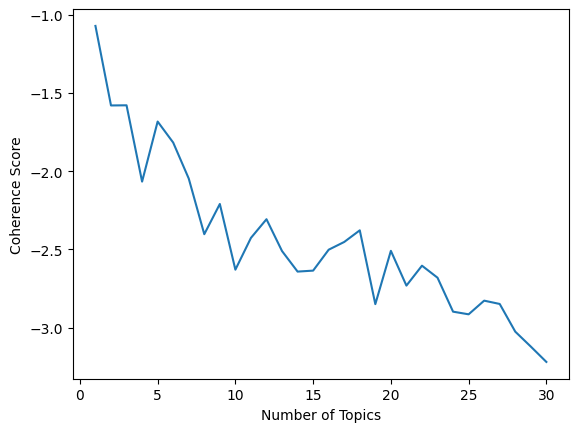

In [17]:
import matplotlib.pyplot as plt

num_topics = [i+1 for i in range(len(scores))]
                                
_=plt.plot(num_topics, scores)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [21]:
# according to the c_v measure, 16 topics looks like a good choice
# let's see what those topics look like

num_tops = 15
models[num_tops - 1].print_topics(num_words = 5)

[(0,
  '0.014*"mouse" + 0.011*"camera" + 0.010*"button" + 0.009*"cd" + 0.007*"player"'),
 (1,
  '0.020*"dvd" + 0.013*"player" + 0.009*"play" + 0.008*"wireless" + 0.007*"case"'),
 (2,
  '0.024*"cable" + 0.009*"return" + 0.009*"phone" + 0.008*"picture" + 0.007*"monster"'),
 (3,
  '0.008*"headphone" + 0.008*"ipod" + 0.008*"set" + 0.007*"print" + 0.007*"money"'),
 (4,
  '0.013*"printer" + 0.009*"phone" + 0.007*"ipod" + 0.007*"print" + 0.007*"wireless"'),
 (5,
  '0.017*"cable" + 0.011*"player" + 0.007*"battery" + 0.007*"amazon" + 0.006*"ipod"'),
 (6,
  '0.018*"card" + 0.014*"case" + 0.009*"computer" + 0.008*"ipod" + 0.008*"warranty"'),
 (7,
  '0.015*"speaker" + 0.009*"headphone" + 0.007*"phone" + 0.007*"set" + 0.007*"bass"'),
 (8,
  '0.012*"speaker" + 0.009*"picture" + 0.008*"cable" + 0.007*"high" + 0.007*"mouse"'),
 (9,
  '0.009*"ipod" + 0.008*"card" + 0.007*"car" + 0.007*"review" + 0.006*"record"'),
 (10,
  '0.027*"phone" + 0.008*"headphone" + 0.007*"mouse" + 0.006*"call" + 0.006*"button"

## Topic Visualization

There is a special library, *pyLDAvis*, that we can use to visualize topic models induced with *gensim* (among other). All you need to do is: 

- import the pyLDAvis package
- allow it to run inside the Jupyter notebook
- instantiate/prepare the display object, feeding the LDA model as an argument
- call the display function

In [19]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook

In [22]:
lda_display = pyLDAvis.gensim_models.prepare(models[num_tops - 1], corpus, dictionary)
pyLDAvis.display(lda_display)